In [1]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.functions import udf, pandas_udf
import re
import nltk
import pandas as pd
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.sentiment import SentimentIntensityAnalyzer
from time import perf_counter

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('vader_lexicon')

[nltk_data] Downloading package stopwords to /home/ubuntu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/ubuntu/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/ubuntu/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

# Tests with 50k dataset

## Test using:
- 1 node
- 4 cores per node
- 5 GiB per executor

In [53]:
spark_session = SparkSession.builder \
    .master("spark://192.168.2.47:7077") \
    .appName("manual_test") \
    .config("spark.dynamicAllocation.enabled", False) \
    .config("spark.dynamicAllocation.shuffleTracking.enabled", True) \
    .config("spark.shuffle.service.enabled", False) \
    .config("spark.dynamicAllocation.executorIdleTimeout", "30s") \
    .config("spark.executor.instances", "1") \
    .config("spark.executor.memory", "5G") \
    .config("spark.cores.max", "4") \
    .getOrCreate()

# RDD API
spark_context = spark_session.sparkContext
spark_context.setLogLevel("ERROR")

In [54]:
# Loading the dataset without the corrupted values
df = spark_session.read.option("mode", "DROPMALFORMED").json("hdfs://192.168.2.47:9000/data-project/reddit_50k.json")

In [55]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
sia = SentimentIntensityAnalyzer()

@pandas_udf("string")
def preprocess_text_udf(text_series: pd.Series) -> pd.Series:
    def preprocess(text):
        # Lowercase the text
        text = text.lower()
        
        # Remove special characters and extra spaces
        text = re.sub(r'\W+', ' ', text)
        
        # Split text into words
        words = text.split()
    
        # Remove stopwords
        words = [w for w in words if w not in stop_words]
    
        # Lemmatize words
        words = [lemmatizer.lemmatize(w) for w in words]
    
        out_text = ' '.join(words)
    
        return out_text

    return text_series.apply(preprocess)

@pandas_udf("float")
def sentiment_score_udf(text_series: pd.Series) -> pd.Series:
    return text_series.apply(lambda text: sia.polarity_scores(text)['compound'])

@pandas_udf("string")
def sentiment_label_udf(score_series: pd.Series) -> pd.Series:
    def label(score):
        if score > 0.05:
            return 'positive'
        elif score < -0.05:
            return 'negative'
        else:
            return 'neutral'
    return score_series.apply(label)

In [56]:
init_time = perf_counter()

df_prep = df.drop('body', 'content', 'id', 'subreddit_id', 'title', 'author', 'content_len', 'summary', 'summary_len')

k = 25 # number of subreddits to consider
df_top = df_prep.select('subreddit') \
                .groupBy('subreddit').count() \
                .sort('count', ascending=False) \
                .limit(k)

topk_subreddits = [df_top.collect()[i][0] for i in range(k)]

df_topk = df_prep.filter(df_prep['subreddit'].isin(topk_subreddits))

df_topk = df_topk.withColumn("clean_text", preprocess_text_udf(df_topk['normalizedBody']))

df_vader = df_topk.withColumn("sentiment_score", sentiment_score_udf(df_topk['clean_text']))
df_vader = df_vader.withColumn("sentiment_label", sentiment_label_udf(df_vader['sentiment_score']))

df_avg = df_vader.groupBy("subreddit") \
                 .agg(F.round(F.avg("sentiment_score"), 4).alias("avg_sentiment_score")) \
                 .limit(k)

df_avg = df_avg.withColumn("sentiment_label", sentiment_label_udf(df_avg['avg_sentiment_score']))

df_avg.show(k)

end_time = perf_counter()

elapsed_time_1 = end_time - init_time

[Stage 52:=============================>                            (1 + 1) / 2]

+-------------------+-------------------+---------------+
|          subreddit|avg_sentiment_score|sentiment_label|
+-------------------+-------------------+---------------+
|         offmychest|             0.2412|       positive|
|          AskReddit|             0.1281|       positive|
|             videos|             0.0718|       positive|
|              DotA2|             0.3839|       positive|
|      todayilearned|             0.1156|       positive|
|      AdviceAnimals|              0.074|       positive|
|     DestinyTheGame|              0.377|       positive|
|      relationships|             0.4971|       positive|
|               pics|             0.0994|       positive|
|            Fitness|             0.3721|       positive|
|         reddit.com|              0.242|       positive|
|          worldnews|            -0.1374|       negative|
|    TwoXChromosomes|             0.3153|       positive|
|           politics|             0.0821|       positive|
|             

In [57]:
print(f"Processing time using 1 node: {elapsed_time_1}")

Processing time using 1 node: 79.780364643957


In [58]:
spark_session.stop()

## Test using:
- 2 nodes
- 4 cores per node
- 5 GiB per executor

In [59]:
spark_session = SparkSession.builder \
    .master("spark://192.168.2.47:7077") \
    .appName("manual_test") \
    .config("spark.dynamicAllocation.enabled", True) \
    .config("spark.dynamicAllocation.shuffleTracking.enabled", True) \
    .config("spark.shuffle.service.enabled", False) \
    .config("spark.dynamicAllocation.executorIdleTimeout", "30s") \
    .config("spark.executor.instances", "2") \
    .config("spark.executor.memory", "5G") \
    .config("spark.cores.max", "8") \
    .getOrCreate()

# RDD API
spark_context = spark_session.sparkContext
spark_context.setLogLevel("ERROR")

In [61]:
df = spark_session.read.option("mode", "DROPMALFORMED").json("hdfs://192.168.2.47:9000/data-project/reddit_50k.json")

In [62]:
init_time = perf_counter()

df_prep = df.drop('body', 'content', 'id', 'subreddit_id', 'title', 'author', 'content_len', 'summary', 'summary_len')

k = 25 # number of subreddits to consider
df_top = df_prep.select('subreddit') \
                .groupBy('subreddit').count() \
                .sort('count', ascending=False) \
                .limit(k)

topk_subreddits = [df_top.collect()[i][0] for i in range(k)]

df_topk = df_prep.filter(df_prep['subreddit'].isin(topk_subreddits))

df_topk = df_topk.withColumn("clean_text", preprocess_text_udf(df_topk['normalizedBody']))

df_vader = df_topk.withColumn("sentiment_score", sentiment_score_udf(df_topk['clean_text']))
df_vader = df_vader.withColumn("sentiment_label", sentiment_label_udf(df_vader['sentiment_score']))

df_avg = df_vader.groupBy("subreddit") \
                 .agg(F.round(F.avg("sentiment_score"), 4).alias("avg_sentiment_score")) \
                 .limit(k)

df_avg = df_avg.withColumn("sentiment_label", sentiment_label_udf(df_avg['avg_sentiment_score']))

df_avg.show(k)

end_time = perf_counter()

elapsed_time_2 = end_time - init_time

25/03/20 21:41:03 ERROR DAGScheduler: Failed to update accumulator 9566 (org.apache.spark.api.python.PythonAccumulatorV2) for task 1
org.apache.spark.SparkException: EOF reached before Python server acknowledged
	at org.apache.spark.api.python.PythonAccumulatorV2.merge(PythonRDD.scala:751)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$updateAccumulators$1(DAGScheduler.scala:1694)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$updateAccumulators$1$adapted(DAGScheduler.scala:1685)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.foreach$(ResizableArray.scala:55)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.updateAccumulators(DAGScheduler.scala:1685)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskCompletion(DAGScheduler.scala:1838)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:3054)
	a

+-------------------+-------------------+---------------+
|          subreddit|avg_sentiment_score|sentiment_label|
+-------------------+-------------------+---------------+
|         offmychest|             0.2412|       positive|
|          AskReddit|             0.1281|       positive|
|             videos|             0.0718|       positive|
|              DotA2|             0.3839|       positive|
|      todayilearned|             0.1156|       positive|
|      AdviceAnimals|              0.074|       positive|
|     DestinyTheGame|              0.377|       positive|
|      relationships|             0.4971|       positive|
|               pics|             0.0994|       positive|
|            Fitness|             0.3721|       positive|
|         reddit.com|              0.242|       positive|
|          worldnews|            -0.1374|       negative|
|    TwoXChromosomes|             0.3153|       positive|
|           politics|             0.0821|       positive|
|             

25/03/20 21:41:07 ERROR DAGScheduler: Failed to update accumulator 9566 (org.apache.spark.api.python.PythonAccumulatorV2) for task 0
java.net.SocketException: Broken pipe (Write failed)
	at java.net.SocketOutputStream.socketWrite0(Native Method)
	at java.net.SocketOutputStream.socketWrite(SocketOutputStream.java:111)
	at java.net.SocketOutputStream.write(SocketOutputStream.java:155)
	at java.io.BufferedOutputStream.flushBuffer(BufferedOutputStream.java:82)
	at java.io.BufferedOutputStream.flush(BufferedOutputStream.java:140)
	at java.io.DataOutputStream.flush(DataOutputStream.java:123)
	at org.apache.spark.api.python.PythonAccumulatorV2.merge(PythonRDD.scala:747)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$updateAccumulators$1(DAGScheduler.scala:1694)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$updateAccumulators$1$adapted(DAGScheduler.scala:1685)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.f

In [63]:
print(f"Processing time using 2 nodes: {elapsed_time_2}")

Processing time using 2 nodes: 48.312987883982714


In [64]:
spark_session.stop()

## Test using:
- 3 nodes
- 4 cores per node
- 5 GiB per executor

In [65]:
spark_session = SparkSession.builder \
    .master("spark://192.168.2.47:7077") \
    .appName("manual_test") \
    .config("spark.dynamicAllocation.enabled", True) \
    .config("spark.dynamicAllocation.shuffleTracking.enabled", True) \
    .config("spark.shuffle.service.enabled", False) \
    .config("spark.dynamicAllocation.executorIdleTimeout", "30s") \
    .config("spark.executor.instances", "3") \
    .config("spark.executor.memory", "5G") \
    .config("spark.cores.max", "12") \
    .getOrCreate()

# RDD API
spark_context = spark_session.sparkContext
spark_context.setLogLevel("ERROR")

In [66]:
df = spark_session.read.option("mode", "DROPMALFORMED").json("hdfs://192.168.2.47:9000/data-project/reddit_50k.json")

In [67]:
init_time = perf_counter()

df_prep = df.drop('body', 'content', 'id', 'subreddit_id', 'title', 'author', 'content_len', 'summary', 'summary_len')

k = 25 # number of subreddits to consider
df_top = df_prep.select('subreddit') \
                .groupBy('subreddit').count() \
                .sort('count', ascending=False) \
                .limit(k)

topk_subreddits = [df_top.collect()[i][0] for i in range(k)]

df_topk = df_prep.filter(df_prep['subreddit'].isin(topk_subreddits))

df_topk = df_topk.withColumn("clean_text", preprocess_text_udf(df_topk['normalizedBody']))

df_vader = df_topk.withColumn("sentiment_score", sentiment_score_udf(df_topk['clean_text']))
df_vader = df_vader.withColumn("sentiment_label", sentiment_label_udf(df_vader['sentiment_score']))

df_avg = df_vader.groupBy("subreddit") \
                 .agg(F.round(F.avg("sentiment_score"), 4).alias("avg_sentiment_score")) \
                 .limit(k)

df_avg = df_avg.withColumn("sentiment_label", sentiment_label_udf(df_avg['avg_sentiment_score']))

df_avg.show(k)

end_time = perf_counter()

elapsed_time_3 = end_time - init_time

25/03/20 21:41:47 ERROR DAGScheduler: Failed to update accumulator 9566 (org.apache.spark.api.python.PythonAccumulatorV2) for task 3
java.net.SocketException: Broken pipe (Write failed)
	at java.net.SocketOutputStream.socketWrite0(Native Method)
	at java.net.SocketOutputStream.socketWrite(SocketOutputStream.java:111)
	at java.net.SocketOutputStream.write(SocketOutputStream.java:155)
	at java.io.BufferedOutputStream.flushBuffer(BufferedOutputStream.java:82)
	at java.io.BufferedOutputStream.flush(BufferedOutputStream.java:140)
	at java.io.DataOutputStream.flush(DataOutputStream.java:123)
	at org.apache.spark.api.python.PythonAccumulatorV2.merge(PythonRDD.scala:747)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$updateAccumulators$1(DAGScheduler.scala:1694)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$updateAccumulators$1$adapted(DAGScheduler.scala:1685)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.f

+-------------------+-------------------+---------------+
|          subreddit|avg_sentiment_score|sentiment_label|
+-------------------+-------------------+---------------+
|         offmychest|             0.2412|       positive|
|          AskReddit|             0.1281|       positive|
|             videos|             0.0718|       positive|
|              DotA2|             0.3839|       positive|
|      todayilearned|             0.1156|       positive|
|      AdviceAnimals|              0.074|       positive|
|     DestinyTheGame|              0.377|       positive|
|      relationships|             0.4971|       positive|
|               pics|             0.0994|       positive|
|            Fitness|             0.3721|       positive|
|         reddit.com|              0.242|       positive|
|          worldnews|            -0.1374|       negative|
|    TwoXChromosomes|             0.3153|       positive|
|           politics|             0.0821|       positive|
|             

25/03/20 21:41:50 ERROR DAGScheduler: Failed to update accumulator 9566 (org.apache.spark.api.python.PythonAccumulatorV2) for task 0
java.net.SocketException: Broken pipe (Write failed)
	at java.net.SocketOutputStream.socketWrite0(Native Method)
	at java.net.SocketOutputStream.socketWrite(SocketOutputStream.java:111)
	at java.net.SocketOutputStream.write(SocketOutputStream.java:155)
	at java.io.BufferedOutputStream.flushBuffer(BufferedOutputStream.java:82)
	at java.io.BufferedOutputStream.flush(BufferedOutputStream.java:140)
	at java.io.DataOutputStream.flush(DataOutputStream.java:123)
	at org.apache.spark.api.python.PythonAccumulatorV2.merge(PythonRDD.scala:747)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$updateAccumulators$1(DAGScheduler.scala:1694)
	at org.apache.spark.scheduler.DAGScheduler.$anonfun$updateAccumulators$1$adapted(DAGScheduler.scala:1685)
	at scala.collection.mutable.ResizableArray.foreach(ResizableArray.scala:62)
	at scala.collection.mutable.ResizableArray.f

In [68]:
print(f"Processing time using 3 nodes: {elapsed_time_3}")

Processing time using 3 nodes: 32.2671153509873


In [69]:
spark_session.stop()

## Append results from 50k test to a list

In [70]:
times_50k = [elapsed_time_1, elapsed_time_2, elapsed_time_3]

In [71]:
print(times_50k)

[79.780364643957, 48.312987883982714, 32.2671153509873]

# Tests with 100k dataset

## Test using:
- 1 node
- 4 cores per node
- 5 GiB per executor

In [72]:
spark_session = SparkSession.builder \
    .master("spark://192.168.2.47:7077") \
    .appName("manual_test") \
    .config("spark.dynamicAllocation.enabled", False) \
    .config("spark.dynamicAllocation.shuffleTracking.enabled", True) \
    .config("spark.shuffle.service.enabled", False) \
    .config("spark.dynamicAllocation.executorIdleTimeout", "30s") \
    .config("spark.executor.instances", "1") \
    .config("spark.executor.memory", "5G") \
    .config("spark.cores.max", "4") \
    .getOrCreate()

# RDD API
spark_context = spark_session.sparkContext
spark_context.setLogLevel("ERROR")

In [73]:
# Loading the dataset without the corrupted values
df = spark_session.read.option("mode", "DROPMALFORMED").json("hdfs://192.168.2.47:9000/data-project/reddit_100k.json")

In [74]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
sia = SentimentIntensityAnalyzer()

@pandas_udf("string")
def preprocess_text_udf(text_series: pd.Series) -> pd.Series:
    def preprocess(text):
        # Lowercase the text
        text = text.lower()
        
        # Remove special characters and extra spaces
        text = re.sub(r'\W+', ' ', text)
        
        # Split text into words
        words = text.split()
    
        # Remove stopwords
        words = [w for w in words if w not in stop_words]
    
        # Lemmatize words
        words = [lemmatizer.lemmatize(w) for w in words]
    
        out_text = ' '.join(words)
    
        return out_text

    return text_series.apply(preprocess)

@pandas_udf("float")
def sentiment_score_udf(text_series: pd.Series) -> pd.Series:
    return text_series.apply(lambda text: sia.polarity_scores(text)['compound'])

@pandas_udf("string")
def sentiment_label_udf(score_series: pd.Series) -> pd.Series:
    def label(score):
        if score > 0.05:
            return 'positive'
        elif score < -0.05:
            return 'negative'
        else:
            return 'neutral'
    return score_series.apply(label)

In [75]:
init_time = perf_counter()

df_prep = df.drop('body', 'content', 'id', 'subreddit_id', 'title', 'author', 'content_len', 'summary', 'summary_len')

k = 25 # number of subreddits to consider
df_top = df_prep.select('subreddit') \
                .groupBy('subreddit').count() \
                .sort('count', ascending=False) \
                .limit(k)

topk_subreddits = [df_top.collect()[i][0] for i in range(k)]

df_topk = df_prep.filter(df_prep['subreddit'].isin(topk_subreddits))

df_topk = df_topk.withColumn("clean_text", preprocess_text_udf(df_topk['normalizedBody']))

df_vader = df_topk.withColumn("sentiment_score", sentiment_score_udf(df_topk['clean_text']))
df_vader = df_vader.withColumn("sentiment_label", sentiment_label_udf(df_vader['sentiment_score']))

df_avg = df_vader.groupBy("subreddit") \
                 .agg(F.round(F.avg("sentiment_score"), 4).alias("avg_sentiment_score")) \
                 .limit(k)

df_avg = df_avg.withColumn("sentiment_label", sentiment_label_udf(df_avg['avg_sentiment_score']))

df_avg.show(k)

end_time = perf_counter()

elapsed_time_11 = end_time - init_time

[Stage 52:===========================================>              (3 + 1) / 4]

+-------------------+-------------------+---------------+
|          subreddit|avg_sentiment_score|sentiment_label|
+-------------------+-------------------+---------------+
|         offmychest|             0.2605|       positive|
|          AskReddit|             0.1265|       positive|
|             videos|             0.0379|        neutral|
|              DotA2|             0.3994|       positive|
|      todayilearned|             0.1025|       positive|
|      AdviceAnimals|             0.0996|       positive|
|     DestinyTheGame|             0.3594|       positive|
|      relationships|             0.4942|       positive|
|               pics|             0.1113|       positive|
|            Fitness|             0.3716|       positive|
|         reddit.com|             0.2248|       positive|
|          worldnews|            -0.1353|       negative|
|    TwoXChromosomes|             0.3303|       positive|
|           politics|              0.084|       positive|
|             

In [76]:
print(f"Processing time using 1 node: {elapsed_time_11}")

Processing time using 1 node: 149.1443244840484


In [77]:
spark_session.stop()

## Test using:
- 2 nodes
- 4 cores per node
- 5 GiB per executor

In [78]:
spark_session = SparkSession.builder \
    .master("spark://192.168.2.47:7077") \
    .appName("manual_test") \
    .config("spark.dynamicAllocation.enabled", False) \
    .config("spark.dynamicAllocation.shuffleTracking.enabled", True) \
    .config("spark.shuffle.service.enabled", False) \
    .config("spark.dynamicAllocation.executorIdleTimeout", "30s") \
    .config("spark.executor.instances", "2") \
    .config("spark.executor.memory", "5G") \
    .config("spark.cores.max", "8") \
    .getOrCreate()

# RDD API
spark_context = spark_session.sparkContext
spark_context.setLogLevel("ERROR")

In [79]:
# Loading the dataset without the corrupted values
df = spark_session.read.option("mode", "DROPMALFORMED").json("hdfs://192.168.2.47:9000/data-project/reddit_100k.json")

In [80]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
sia = SentimentIntensityAnalyzer()

@pandas_udf("string")
def preprocess_text_udf(text_series: pd.Series) -> pd.Series:
    def preprocess(text):
        # Lowercase the text
        text = text.lower()
        
        # Remove special characters and extra spaces
        text = re.sub(r'\W+', ' ', text)
        
        # Split text into words
        words = text.split()
    
        # Remove stopwords
        words = [w for w in words if w not in stop_words]
    
        # Lemmatize words
        words = [lemmatizer.lemmatize(w) for w in words]
    
        out_text = ' '.join(words)
    
        return out_text

    return text_series.apply(preprocess)

@pandas_udf("float")
def sentiment_score_udf(text_series: pd.Series) -> pd.Series:
    return text_series.apply(lambda text: sia.polarity_scores(text)['compound'])

@pandas_udf("string")
def sentiment_label_udf(score_series: pd.Series) -> pd.Series:
    def label(score):
        if score > 0.05:
            return 'positive'
        elif score < -0.05:
            return 'negative'
        else:
            return 'neutral'
    return score_series.apply(label)

In [81]:
init_time = perf_counter()

df_prep = df.drop('body', 'content', 'id', 'subreddit_id', 'title', 'author', 'content_len', 'summary', 'summary_len')

k = 25 # number of subreddits to consider
df_top = df_prep.select('subreddit') \
                .groupBy('subreddit').count() \
                .sort('count', ascending=False) \
                .limit(k)

topk_subreddits = [df_top.collect()[i][0] for i in range(k)]

df_topk = df_prep.filter(df_prep['subreddit'].isin(topk_subreddits))

df_topk = df_topk.withColumn("clean_text", preprocess_text_udf(df_topk['normalizedBody']))

df_vader = df_topk.withColumn("sentiment_score", sentiment_score_udf(df_topk['clean_text']))
df_vader = df_vader.withColumn("sentiment_label", sentiment_label_udf(df_vader['sentiment_score']))

df_avg = df_vader.groupBy("subreddit") \
                 .agg(F.round(F.avg("sentiment_score"), 4).alias("avg_sentiment_score")) \
                 .limit(k)

df_avg = df_avg.withColumn("sentiment_label", sentiment_label_udf(df_avg['avg_sentiment_score']))

df_avg.show(k)

end_time = perf_counter()

elapsed_time_21 = end_time - init_time

[Stage 52:===========================================>              (3 + 1) / 4]

+-------------------+-------------------+---------------+
|          subreddit|avg_sentiment_score|sentiment_label|
+-------------------+-------------------+---------------+
|         offmychest|             0.2605|       positive|
|          AskReddit|             0.1265|       positive|
|             videos|             0.0379|        neutral|
|              DotA2|             0.3994|       positive|
|      todayilearned|             0.1025|       positive|
|      AdviceAnimals|             0.0996|       positive|
|     DestinyTheGame|             0.3594|       positive|
|      relationships|             0.4942|       positive|
|               pics|             0.1113|       positive|
|            Fitness|             0.3716|       positive|
|         reddit.com|             0.2248|       positive|
|          worldnews|            -0.1353|       negative|
|    TwoXChromosomes|             0.3303|       positive|
|           politics|              0.084|       positive|
|             

In [82]:
print(f"Processing time using 2 nodes: {elapsed_time_21}")

Processing time using 2 nodes: 86.01410643401323


In [83]:
spark_session.stop()

## Test using:
- 3 nodes
- 4 cores per node
- 5 GiB per executor

In [84]:
spark_session = SparkSession.builder \
    .master("spark://192.168.2.47:7077") \
    .appName("manual_test") \
    .config("spark.dynamicAllocation.enabled", False) \
    .config("spark.dynamicAllocation.shuffleTracking.enabled", True) \
    .config("spark.shuffle.service.enabled", False) \
    .config("spark.dynamicAllocation.executorIdleTimeout", "30s") \
    .config("spark.executor.instances", "3") \
    .config("spark.executor.memory", "5G") \
    .config("spark.cores.max", "12") \
    .getOrCreate()

# RDD API
spark_context = spark_session.sparkContext
spark_context.setLogLevel("ERROR")

In [85]:
# Loading the dataset without the corrupted values
df = spark_session.read.option("mode", "DROPMALFORMED").json("hdfs://192.168.2.47:9000/data-project/reddit_100k.json")

In [86]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
sia = SentimentIntensityAnalyzer()

@pandas_udf("string")
def preprocess_text_udf(text_series: pd.Series) -> pd.Series:
    def preprocess(text):
        # Lowercase the text
        text = text.lower()
        
        # Remove special characters and extra spaces
        text = re.sub(r'\W+', ' ', text)
        
        # Split text into words
        words = text.split()
    
        # Remove stopwords
        words = [w for w in words if w not in stop_words]
    
        # Lemmatize words
        words = [lemmatizer.lemmatize(w) for w in words]
    
        out_text = ' '.join(words)
    
        return out_text

    return text_series.apply(preprocess)

@pandas_udf("float")
def sentiment_score_udf(text_series: pd.Series) -> pd.Series:
    return text_series.apply(lambda text: sia.polarity_scores(text)['compound'])

@pandas_udf("string")
def sentiment_label_udf(score_series: pd.Series) -> pd.Series:
    def label(score):
        if score > 0.05:
            return 'positive'
        elif score < -0.05:
            return 'negative'
        else:
            return 'neutral'
    return score_series.apply(label)

In [87]:
init_time = perf_counter()

df_prep = df.drop('body', 'content', 'id', 'subreddit_id', 'title', 'author', 'content_len', 'summary', 'summary_len')

k = 25 # number of subreddits to consider
df_top = df_prep.select('subreddit') \
                .groupBy('subreddit').count() \
                .sort('count', ascending=False) \
                .limit(k)

topk_subreddits = [df_top.collect()[i][0] for i in range(k)]

df_topk = df_prep.filter(df_prep['subreddit'].isin(topk_subreddits))

df_topk = df_topk.withColumn("clean_text", preprocess_text_udf(df_topk['normalizedBody']))

df_vader = df_topk.withColumn("sentiment_score", sentiment_score_udf(df_topk['clean_text']))
df_vader = df_vader.withColumn("sentiment_label", sentiment_label_udf(df_vader['sentiment_score']))

df_avg = df_vader.groupBy("subreddit") \
                 .agg(F.round(F.avg("sentiment_score"), 4).alias("avg_sentiment_score")) \
                 .limit(k)

df_avg = df_avg.withColumn("sentiment_label", sentiment_label_udf(df_avg['avg_sentiment_score']))

df_avg.show(k)

end_time = perf_counter()

elapsed_time_31 = end_time - init_time

[Stage 52:===========================================>              (3 + 1) / 4]

+-------------------+-------------------+---------------+
|          subreddit|avg_sentiment_score|sentiment_label|
+-------------------+-------------------+---------------+
|         offmychest|             0.2605|       positive|
|          AskReddit|             0.1265|       positive|
|             videos|             0.0379|        neutral|
|              DotA2|             0.3994|       positive|
|      todayilearned|             0.1025|       positive|
|      AdviceAnimals|             0.0996|       positive|
|     DestinyTheGame|             0.3594|       positive|
|      relationships|             0.4942|       positive|
|               pics|             0.1113|       positive|
|            Fitness|             0.3716|       positive|
|         reddit.com|             0.2248|       positive|
|          worldnews|            -0.1353|       negative|
|    TwoXChromosomes|             0.3303|       positive|
|           politics|              0.084|       positive|
|             

In [88]:
print(f"Processing time using 3 nodes: {elapsed_time_31}")

Processing time using 3 nodes: 50.22396920697065


In [89]:
spark_session.stop()

## Append results from 100k dataset to a list

In [90]:
times_100k = [elapsed_time_11, elapsed_time_21, elapsed_time_31]

In [91]:
print(times_100k)

[149.1443244840484, 86.01410643401323, 50.22396920697065]

# Tests with 200k dataset

## Test using:
- 1 node
- 4 cores per node
- 5 GiB per executor

In [92]:
spark_session = SparkSession.builder \
    .master("spark://192.168.2.47:7077") \
    .appName("manual_test") \
    .config("spark.dynamicAllocation.enabled", False) \
    .config("spark.dynamicAllocation.shuffleTracking.enabled", True) \
    .config("spark.shuffle.service.enabled", False) \
    .config("spark.dynamicAllocation.executorIdleTimeout", "30s") \
    .config("spark.executor.instances", "1") \
    .config("spark.executor.memory", "5G") \
    .config("spark.cores.max", "4") \
    .getOrCreate()

# RDD API
spark_context = spark_session.sparkContext
spark_context.setLogLevel("ERROR")

In [93]:
# Loading the dataset without the corrupted values
df = spark_session.read.option("mode", "DROPMALFORMED").json("hdfs://192.168.2.47:9000/data-project/reddit_200k.json")

In [94]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
sia = SentimentIntensityAnalyzer()

@pandas_udf("string")
def preprocess_text_udf(text_series: pd.Series) -> pd.Series:
    def preprocess(text):
        # Lowercase the text
        text = text.lower()
        
        # Remove special characters and extra spaces
        text = re.sub(r'\W+', ' ', text)
        
        # Split text into words
        words = text.split()
    
        # Remove stopwords
        words = [w for w in words if w not in stop_words]
    
        # Lemmatize words
        words = [lemmatizer.lemmatize(w) for w in words]
    
        out_text = ' '.join(words)
    
        return out_text

    return text_series.apply(preprocess)

@pandas_udf("float")
def sentiment_score_udf(text_series: pd.Series) -> pd.Series:
    return text_series.apply(lambda text: sia.polarity_scores(text)['compound'])

@pandas_udf("string")
def sentiment_label_udf(score_series: pd.Series) -> pd.Series:
    def label(score):
        if score > 0.05:
            return 'positive'
        elif score < -0.05:
            return 'negative'
        else:
            return 'neutral'
    return score_series.apply(label)

In [95]:
init_time = perf_counter()

df_prep = df.drop('body', 'content', 'id', 'subreddit_id', 'title', 'author', 'content_len', 'summary', 'summary_len')

k = 25 # number of subreddits to consider
df_top = df_prep.select('subreddit') \
                .groupBy('subreddit').count() \
                .sort('count', ascending=False) \
                .limit(k)

topk_subreddits = [df_top.collect()[i][0] for i in range(k)]

df_topk = df_prep.filter(df_prep['subreddit'].isin(topk_subreddits))

df_topk = df_topk.withColumn("clean_text", preprocess_text_udf(df_topk['normalizedBody']))

df_vader = df_topk.withColumn("sentiment_score", sentiment_score_udf(df_topk['clean_text']))
df_vader = df_vader.withColumn("sentiment_label", sentiment_label_udf(df_vader['sentiment_score']))

df_avg = df_vader.groupBy("subreddit") \
                 .agg(F.round(F.avg("sentiment_score"), 4).alias("avg_sentiment_score")) \
                 .limit(k)

df_avg = df_avg.withColumn("sentiment_label", sentiment_label_udf(df_avg['avg_sentiment_score']))

df_avg.show(k)

end_time = perf_counter()

elapsed_time_12 = end_time - init_time

[Stage 52:==================================================>       (7 + 1) / 8]

+-------------------+-------------------+---------------+
|          subreddit|avg_sentiment_score|sentiment_label|
+-------------------+-------------------+---------------+
|         offmychest|             0.2077|       positive|
|          AskReddit|             0.1279|       positive|
|             videos|             0.0349|        neutral|
|              DotA2|              0.383|       positive|
|      todayilearned|             0.0851|       positive|
|      AdviceAnimals|             0.0773|       positive|
|     DestinyTheGame|             0.3123|       positive|
|      relationships|             0.5021|       positive|
|               pics|             0.1013|       positive|
|            Fitness|             0.4082|       positive|
|         reddit.com|             0.2181|       positive|
|          worldnews|            -0.1139|       negative|
|    TwoXChromosomes|             0.2917|       positive|
|           politics|             0.0862|       positive|
|             

In [96]:
print(f"Processing time using 1 node: {elapsed_time_12}")

Processing time using 1 node: 342.2870891590137


In [97]:
spark_session.stop()

## Test using:
- 2 nodes
- 4 cores per node
- 5 GiB per executor

In [98]:
spark_session = SparkSession.builder \
    .master("spark://192.168.2.47:7077") \
    .appName("manual_test") \
    .config("spark.dynamicAllocation.enabled", False) \
    .config("spark.dynamicAllocation.shuffleTracking.enabled", True) \
    .config("spark.shuffle.service.enabled", False) \
    .config("spark.dynamicAllocation.executorIdleTimeout", "30s") \
    .config("spark.executor.instances", "2") \
    .config("spark.executor.memory", "5G") \
    .config("spark.cores.max", "8") \
    .getOrCreate()

# RDD API
spark_context = spark_session.sparkContext
spark_context.setLogLevel("ERROR")

In [99]:
# Loading the dataset without the corrupted values
df = spark_session.read.option("mode", "DROPMALFORMED").json("hdfs://192.168.2.47:9000/data-project/reddit_200k.json")

In [100]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
sia = SentimentIntensityAnalyzer()

@pandas_udf("string")
def preprocess_text_udf(text_series: pd.Series) -> pd.Series:
    def preprocess(text):
        # Lowercase the text
        text = text.lower()
        
        # Remove special characters and extra spaces
        text = re.sub(r'\W+', ' ', text)
        
        # Split text into words
        words = text.split()
    
        # Remove stopwords
        words = [w for w in words if w not in stop_words]
    
        # Lemmatize words
        words = [lemmatizer.lemmatize(w) for w in words]
    
        out_text = ' '.join(words)
    
        return out_text

    return text_series.apply(preprocess)

@pandas_udf("float")
def sentiment_score_udf(text_series: pd.Series) -> pd.Series:
    return text_series.apply(lambda text: sia.polarity_scores(text)['compound'])

@pandas_udf("string")
def sentiment_label_udf(score_series: pd.Series) -> pd.Series:
    def label(score):
        if score > 0.05:
            return 'positive'
        elif score < -0.05:
            return 'negative'
        else:
            return 'neutral'
    return score_series.apply(label)

In [101]:
init_time = perf_counter()

df_prep = df.drop('body', 'content', 'id', 'subreddit_id', 'title', 'author', 'content_len', 'summary', 'summary_len')

k = 25 # number of subreddits to consider
df_top = df_prep.select('subreddit') \
                .groupBy('subreddit').count() \
                .sort('count', ascending=False) \
                .limit(k)

topk_subreddits = [df_top.collect()[i][0] for i in range(k)]

df_topk = df_prep.filter(df_prep['subreddit'].isin(topk_subreddits))

df_topk = df_topk.withColumn("clean_text", preprocess_text_udf(df_topk['normalizedBody']))

df_vader = df_topk.withColumn("sentiment_score", sentiment_score_udf(df_topk['clean_text']))
df_vader = df_vader.withColumn("sentiment_label", sentiment_label_udf(df_vader['sentiment_score']))

df_avg = df_vader.groupBy("subreddit") \
                 .agg(F.round(F.avg("sentiment_score"), 4).alias("avg_sentiment_score")) \
                 .limit(k)

df_avg = df_avg.withColumn("sentiment_label", sentiment_label_udf(df_avg['avg_sentiment_score']))

df_avg.show(k)

end_time = perf_counter()

elapsed_time_22 = end_time - init_time

[Stage 52:==================================================>       (7 + 1) / 8]

+-------------------+-------------------+---------------+
|          subreddit|avg_sentiment_score|sentiment_label|
+-------------------+-------------------+---------------+
|         offmychest|             0.2077|       positive|
|          AskReddit|             0.1279|       positive|
|             videos|             0.0349|        neutral|
|              DotA2|              0.383|       positive|
|      todayilearned|             0.0851|       positive|
|      AdviceAnimals|             0.0773|       positive|
|     DestinyTheGame|             0.3123|       positive|
|      relationships|             0.5021|       positive|
|               pics|             0.1013|       positive|
|            Fitness|             0.4082|       positive|
|         reddit.com|             0.2181|       positive|
|          worldnews|            -0.1139|       negative|
|    TwoXChromosomes|             0.2917|       positive|
|           politics|             0.0862|       positive|
|             

In [102]:
print(f"Processing time using 2 nodes: {elapsed_time_22}")

Processing time using 2 nodes: 159.77766905602766


In [103]:
spark_session.stop()

## Test using:
- 3 nodes
- 4 cores per node
- 5 GiB per executor

In [104]:
spark_session = SparkSession.builder \
    .master("spark://192.168.2.47:7077") \
    .appName("manual_test") \
    .config("spark.dynamicAllocation.enabled", False) \
    .config("spark.dynamicAllocation.shuffleTracking.enabled", True) \
    .config("spark.shuffle.service.enabled", False) \
    .config("spark.dynamicAllocation.executorIdleTimeout", "30s") \
    .config("spark.executor.instances", "3") \
    .config("spark.executor.memory", "5G") \
    .config("spark.cores.max", "12") \
    .getOrCreate()

# RDD API
spark_context = spark_session.sparkContext
spark_context.setLogLevel("ERROR")

In [105]:
# Loading the dataset without the corrupted values
df = spark_session.read.option("mode", "DROPMALFORMED").json("hdfs://192.168.2.47:9000/data-project/reddit_200k.json")

In [106]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
sia = SentimentIntensityAnalyzer()

@pandas_udf("string")
def preprocess_text_udf(text_series: pd.Series) -> pd.Series:
    def preprocess(text):
        # Lowercase the text
        text = text.lower()
        
        # Remove special characters and extra spaces
        text = re.sub(r'\W+', ' ', text)
        
        # Split text into words
        words = text.split()
    
        # Remove stopwords
        words = [w for w in words if w not in stop_words]
    
        # Lemmatize words
        words = [lemmatizer.lemmatize(w) for w in words]
    
        out_text = ' '.join(words)
    
        return out_text

    return text_series.apply(preprocess)

@pandas_udf("float")
def sentiment_score_udf(text_series: pd.Series) -> pd.Series:
    return text_series.apply(lambda text: sia.polarity_scores(text)['compound'])

@pandas_udf("string")
def sentiment_label_udf(score_series: pd.Series) -> pd.Series:
    def label(score):
        if score > 0.05:
            return 'positive'
        elif score < -0.05:
            return 'negative'
        else:
            return 'neutral'
    return score_series.apply(label)

In [107]:
init_time = perf_counter()

df_prep = df.drop('body', 'content', 'id', 'subreddit_id', 'title', 'author', 'content_len', 'summary', 'summary_len')

k = 25 # number of subreddits to consider
df_top = df_prep.select('subreddit') \
                .groupBy('subreddit').count() \
                .sort('count', ascending=False) \
                .limit(k)

topk_subreddits = [df_top.collect()[i][0] for i in range(k)]

df_topk = df_prep.filter(df_prep['subreddit'].isin(topk_subreddits))

df_topk = df_topk.withColumn("clean_text", preprocess_text_udf(df_topk['normalizedBody']))

df_vader = df_topk.withColumn("sentiment_score", sentiment_score_udf(df_topk['clean_text']))
df_vader = df_vader.withColumn("sentiment_label", sentiment_label_udf(df_vader['sentiment_score']))

df_avg = df_vader.groupBy("subreddit") \
                 .agg(F.round(F.avg("sentiment_score"), 4).alias("avg_sentiment_score")) \
                 .limit(k)

df_avg = df_avg.withColumn("sentiment_label", sentiment_label_udf(df_avg['avg_sentiment_score']))

df_avg.show(k)

end_time = perf_counter()

elapsed_time_32 = end_time - init_time

[Stage 52:==================================================>       (7 + 1) / 8]

+-------------------+-------------------+---------------+
|          subreddit|avg_sentiment_score|sentiment_label|
+-------------------+-------------------+---------------+
|         offmychest|             0.2077|       positive|
|          AskReddit|             0.1279|       positive|
|             videos|             0.0349|        neutral|
|              DotA2|              0.383|       positive|
|      todayilearned|             0.0851|       positive|
|      AdviceAnimals|             0.0773|       positive|
|     DestinyTheGame|             0.3123|       positive|
|      relationships|             0.5021|       positive|
|               pics|             0.1013|       positive|
|            Fitness|             0.4082|       positive|
|         reddit.com|             0.2181|       positive|
|          worldnews|            -0.1139|       negative|
|    TwoXChromosomes|             0.2917|       positive|
|           politics|             0.0862|       positive|
|             

In [108]:
print(f"Processing time using 3 nodes: {elapsed_time_32}")

Processing time using 3 nodes: 90.342039183015


In [109]:
spark_session.stop()

## Append results from 200k dataset to a list

In [110]:
times_200k = [elapsed_time_12, elapsed_time_22, elapsed_time_32]

In [111]:
print(times_200k)

[342.2870891590137, 159.77766905602766, 90.342039183015]


# Tests with 500k dataset

## Test using:
- 1 node
- 4 cores per node
- 5 GiB per executor

In [114]:
spark_session = SparkSession.builder \
    .master("spark://192.168.2.47:7077") \
    .appName("manual_test") \
    .config("spark.dynamicAllocation.enabled", False) \
    .config("spark.dynamicAllocation.shuffleTracking.enabled", True) \
    .config("spark.shuffle.service.enabled", False) \
    .config("spark.dynamicAllocation.executorIdleTimeout", "30s") \
    .config("spark.executor.instances", "1") \
    .config("spark.executor.memory", "5G") \
    .config("spark.cores.max", "4") \
    .getOrCreate()

# RDD API
spark_context = spark_session.sparkContext
spark_context.setLogLevel("ERROR")

In [115]:
# Loading the dataset without the corrupted values
df = spark_session.read.option("mode", "DROPMALFORMED").json("hdfs://192.168.2.47:9000/data-project/reddit_500k.json")

In [116]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
sia = SentimentIntensityAnalyzer()

@pandas_udf("string")
def preprocess_text_udf(text_series: pd.Series) -> pd.Series:
    def preprocess(text):
        # Lowercase the text
        text = text.lower()
        
        # Remove special characters and extra spaces
        text = re.sub(r'\W+', ' ', text)
        
        # Split text into words
        words = text.split()
    
        # Remove stopwords
        words = [w for w in words if w not in stop_words]
    
        # Lemmatize words
        words = [lemmatizer.lemmatize(w) for w in words]
    
        out_text = ' '.join(words)
    
        return out_text

    return text_series.apply(preprocess)

@pandas_udf("float")
def sentiment_score_udf(text_series: pd.Series) -> pd.Series:
    return text_series.apply(lambda text: sia.polarity_scores(text)['compound'])

@pandas_udf("string")
def sentiment_label_udf(score_series: pd.Series) -> pd.Series:
    def label(score):
        if score > 0.05:
            return 'positive'
        elif score < -0.05:
            return 'negative'
        else:
            return 'neutral'
    return score_series.apply(label)

In [117]:
init_time = perf_counter()

df_prep = df.drop('body', 'content', 'id', 'subreddit_id', 'title', 'author', 'content_len', 'summary', 'summary_len')

k = 25 # number of subreddits to consider
df_top = df_prep.select('subreddit') \
                .groupBy('subreddit').count() \
                .sort('count', ascending=False) \
                .limit(k)

topk_subreddits = [df_top.collect()[i][0] for i in range(k)]

df_topk = df_prep.filter(df_prep['subreddit'].isin(topk_subreddits))

df_topk = df_topk.withColumn("clean_text", preprocess_text_udf(df_topk['normalizedBody']))

df_vader = df_topk.withColumn("sentiment_score", sentiment_score_udf(df_topk['clean_text']))
df_vader = df_vader.withColumn("sentiment_label", sentiment_label_udf(df_vader['sentiment_score']))

df_avg = df_vader.groupBy("subreddit") \
                 .agg(F.round(F.avg("sentiment_score"), 4).alias("avg_sentiment_score")) \
                 .limit(k)

df_avg = df_avg.withColumn("sentiment_label", sentiment_label_udf(df_avg['avg_sentiment_score']))

df_avg.show(k)

end_time = perf_counter()

elapsed_time_13 = end_time - init_time

[Stage 52:=====================================================>  (18 + 1) / 19]

+-------------------+-------------------+---------------+
|          subreddit|avg_sentiment_score|sentiment_label|
+-------------------+-------------------+---------------+
|         offmychest|             0.2141|       positive|
|          AskReddit|             0.1256|       positive|
|             videos|             0.0422|        neutral|
|              DotA2|             0.3998|       positive|
|      todayilearned|             0.0623|       positive|
|      AdviceAnimals|             0.0715|       positive|
|     DestinyTheGame|             0.3092|       positive|
|      relationships|             0.4976|       positive|
|               pics|             0.1072|       positive|
|            Fitness|             0.4108|       positive|
|         reddit.com|             0.2059|       positive|
|          worldnews|            -0.1014|       negative|
|    TwoXChromosomes|             0.3029|       positive|
|           politics|             0.0894|       positive|
|             

In [118]:
print(f"Processing time using 1 node: {elapsed_time_13}")

Processing time using 1 node: 819.6431082779891


In [119]:
spark_session.stop()

## Test using:
- 2 nodes
- 4 cores per node
- 5 GiB per executor

In [120]:
spark_session = SparkSession.builder \
    .master("spark://192.168.2.47:7077") \
    .appName("manual_test") \
    .config("spark.dynamicAllocation.enabled", False) \
    .config("spark.dynamicAllocation.shuffleTracking.enabled", True) \
    .config("spark.shuffle.service.enabled", False) \
    .config("spark.dynamicAllocation.executorIdleTimeout", "30s") \
    .config("spark.executor.instances", "2") \
    .config("spark.executor.memory", "5G") \
    .config("spark.cores.max", "8") \
    .getOrCreate()

# RDD API
spark_context = spark_session.sparkContext
spark_context.setLogLevel("ERROR")

In [121]:
# Loading the dataset without the corrupted values
df = spark_session.read.option("mode", "DROPMALFORMED").json("hdfs://192.168.2.47:9000/data-project/reddit_500k.json")

In [122]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
sia = SentimentIntensityAnalyzer()

@pandas_udf("string")
def preprocess_text_udf(text_series: pd.Series) -> pd.Series:
    def preprocess(text):
        # Lowercase the text
        text = text.lower()
        
        # Remove special characters and extra spaces
        text = re.sub(r'\W+', ' ', text)
        
        # Split text into words
        words = text.split()
    
        # Remove stopwords
        words = [w for w in words if w not in stop_words]
    
        # Lemmatize words
        words = [lemmatizer.lemmatize(w) for w in words]
    
        out_text = ' '.join(words)
    
        return out_text

    return text_series.apply(preprocess)

@pandas_udf("float")
def sentiment_score_udf(text_series: pd.Series) -> pd.Series:
    return text_series.apply(lambda text: sia.polarity_scores(text)['compound'])

@pandas_udf("string")
def sentiment_label_udf(score_series: pd.Series) -> pd.Series:
    def label(score):
        if score > 0.05:
            return 'positive'
        elif score < -0.05:
            return 'negative'
        else:
            return 'neutral'
    return score_series.apply(label)

In [123]:
init_time = perf_counter()

df_prep = df.drop('body', 'content', 'id', 'subreddit_id', 'title', 'author', 'content_len', 'summary', 'summary_len')

k = 25 # number of subreddits to consider
df_top = df_prep.select('subreddit') \
                .groupBy('subreddit').count() \
                .sort('count', ascending=False) \
                .limit(k)

topk_subreddits = [df_top.collect()[i][0] for i in range(k)]

df_topk = df_prep.filter(df_prep['subreddit'].isin(topk_subreddits))

df_topk = df_topk.withColumn("clean_text", preprocess_text_udf(df_topk['normalizedBody']))

df_vader = df_topk.withColumn("sentiment_score", sentiment_score_udf(df_topk['clean_text']))
df_vader = df_vader.withColumn("sentiment_label", sentiment_label_udf(df_vader['sentiment_score']))

df_avg = df_vader.groupBy("subreddit") \
                 .agg(F.round(F.avg("sentiment_score"), 4).alias("avg_sentiment_score")) \
                 .limit(k)

df_avg = df_avg.withColumn("sentiment_label", sentiment_label_udf(df_avg['avg_sentiment_score']))

df_avg.show(k)

end_time = perf_counter()

elapsed_time_23 = end_time - init_time

[Stage 52:=====================================================>  (18 + 1) / 19]

+-------------------+-------------------+---------------+
|          subreddit|avg_sentiment_score|sentiment_label|
+-------------------+-------------------+---------------+
|         offmychest|             0.2141|       positive|
|          AskReddit|             0.1256|       positive|
|             videos|             0.0422|        neutral|
|              DotA2|             0.3998|       positive|
|      todayilearned|             0.0623|       positive|
|      AdviceAnimals|             0.0715|       positive|
|     DestinyTheGame|             0.3092|       positive|
|      relationships|             0.4976|       positive|
|               pics|             0.1072|       positive|
|            Fitness|             0.4108|       positive|
|         reddit.com|             0.2059|       positive|
|          worldnews|            -0.1014|       negative|
|    TwoXChromosomes|             0.3029|       positive|
|           politics|             0.0894|       positive|
|             

In [124]:
print(f"Processing time using 2 nodes: {elapsed_time_23}")

Processing time using 2 nodes: 392.5954315380077


In [125]:
spark_session.stop()

## Test using:
- 3 nodes
- 4 cores per node
- 5 GiB per executor

In [126]:
spark_session = SparkSession.builder \
    .master("spark://192.168.2.47:7077") \
    .appName("manual_test") \
    .config("spark.dynamicAllocation.enabled", False) \
    .config("spark.dynamicAllocation.shuffleTracking.enabled", True) \
    .config("spark.shuffle.service.enabled", False) \
    .config("spark.dynamicAllocation.executorIdleTimeout", "30s") \
    .config("spark.executor.instances", "3") \
    .config("spark.executor.memory", "5G") \
    .config("spark.cores.max", "12") \
    .getOrCreate()

# RDD API
spark_context = spark_session.sparkContext
spark_context.setLogLevel("ERROR")

In [127]:
# Loading the dataset without the corrupted values
df = spark_session.read.option("mode", "DROPMALFORMED").json("hdfs://192.168.2.47:9000/data-project/reddit_500k.json")

In [128]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
sia = SentimentIntensityAnalyzer()

@pandas_udf("string")
def preprocess_text_udf(text_series: pd.Series) -> pd.Series:
    def preprocess(text):
        # Lowercase the text
        text = text.lower()
        
        # Remove special characters and extra spaces
        text = re.sub(r'\W+', ' ', text)
        
        # Split text into words
        words = text.split()
    
        # Remove stopwords
        words = [w for w in words if w not in stop_words]
    
        # Lemmatize words
        words = [lemmatizer.lemmatize(w) for w in words]
    
        out_text = ' '.join(words)
    
        return out_text

    return text_series.apply(preprocess)

@pandas_udf("float")
def sentiment_score_udf(text_series: pd.Series) -> pd.Series:
    return text_series.apply(lambda text: sia.polarity_scores(text)['compound'])

@pandas_udf("string")
def sentiment_label_udf(score_series: pd.Series) -> pd.Series:
    def label(score):
        if score > 0.05:
            return 'positive'
        elif score < -0.05:
            return 'negative'
        else:
            return 'neutral'
    return score_series.apply(label)

In [129]:
init_time = perf_counter()

df_prep = df.drop('body', 'content', 'id', 'subreddit_id', 'title', 'author', 'content_len', 'summary', 'summary_len')

k = 25 # number of subreddits to consider
df_top = df_prep.select('subreddit') \
                .groupBy('subreddit').count() \
                .sort('count', ascending=False) \
                .limit(k)

topk_subreddits = [df_top.collect()[i][0] for i in range(k)]

df_topk = df_prep.filter(df_prep['subreddit'].isin(topk_subreddits))

df_topk = df_topk.withColumn("clean_text", preprocess_text_udf(df_topk['normalizedBody']))

df_vader = df_topk.withColumn("sentiment_score", sentiment_score_udf(df_topk['clean_text']))
df_vader = df_vader.withColumn("sentiment_label", sentiment_label_udf(df_vader['sentiment_score']))

df_avg = df_vader.groupBy("subreddit") \
                 .agg(F.round(F.avg("sentiment_score"), 4).alias("avg_sentiment_score")) \
                 .limit(k)

df_avg = df_avg.withColumn("sentiment_label", sentiment_label_udf(df_avg['avg_sentiment_score']))

df_avg.show(k)

end_time = perf_counter()

elapsed_time_33 = end_time - init_time

[Stage 54:>                                                         (0 + 1) / 1]

+-------------------+-------------------+---------------+
|          subreddit|avg_sentiment_score|sentiment_label|
+-------------------+-------------------+---------------+
|         offmychest|             0.2141|       positive|
|          AskReddit|             0.1256|       positive|
|             videos|             0.0422|        neutral|
|              DotA2|             0.3998|       positive|
|      todayilearned|             0.0623|       positive|
|      AdviceAnimals|             0.0715|       positive|
|     DestinyTheGame|             0.3092|       positive|
|      relationships|             0.4976|       positive|
|               pics|             0.1072|       positive|
|            Fitness|             0.4108|       positive|
|         reddit.com|             0.2059|       positive|
|          worldnews|            -0.1014|       negative|
|    TwoXChromosomes|             0.3029|       positive|
|           politics|             0.0894|       positive|
|             

In [130]:
print(f"Processing time using 3 nodes: {elapsed_time_33}")

Processing time using 3 nodes: 206.61554143298417


In [131]:
spark_session.stop()

## Append results from 500k dataset to a list

In [132]:
times_500k = [elapsed_time_13, elapsed_time_23, elapsed_time_33]

In [133]:
print(times_500k)

[819.6431082779891, 392.5954315380077, 206.61554143298417]


# Tests with the complete dataset

## Test using:
- 1 node
- 4 cores per node
- 5 GiB per executor

In [2]:
spark_session = SparkSession.builder \
    .master("spark://192.168.2.47:7077") \
    .appName("manual_test") \
    .config("spark.dynamicAllocation.enabled", False) \
    .config("spark.dynamicAllocation.shuffleTracking.enabled", True) \
    .config("spark.shuffle.service.enabled", False) \
    .config("spark.dynamicAllocation.executorIdleTimeout", "30s") \
    .config("spark.executor.instances", "1") \
    .config("spark.executor.memory", "5G") \
    .config("spark.cores.max", "4") \
    .getOrCreate()

# RDD API
spark_context = spark_session.sparkContext
spark_context.setLogLevel("ERROR")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/03/21 12:44:53 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [3]:
# Loading the dataset without the corrupted values
df = spark_session.read.option("mode", "DROPMALFORMED").json("hdfs://192.168.2.47:9000/data-project/corpus-webis-tldr-17.json")

In [4]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
sia = SentimentIntensityAnalyzer()

@pandas_udf("string")
def preprocess_text_udf(text_series: pd.Series) -> pd.Series:
    def preprocess(text):
        # Lowercase the text
        text = text.lower()
        
        # Remove special characters and extra spaces
        text = re.sub(r'\W+', ' ', text)
        
        # Split text into words
        words = text.split()
    
        # Remove stopwords
        words = [w for w in words if w not in stop_words]
    
        # Lemmatize words
        words = [lemmatizer.lemmatize(w) for w in words]
    
        out_text = ' '.join(words)
    
        return out_text

    return text_series.apply(preprocess)

@pandas_udf("float")
def sentiment_score_udf(text_series: pd.Series) -> pd.Series:
    return text_series.apply(lambda text: sia.polarity_scores(text)['compound'])

@pandas_udf("string")
def sentiment_label_udf(score_series: pd.Series) -> pd.Series:
    def label(score):
        if score > 0.05:
            return 'positive'
        elif score < -0.05:
            return 'negative'
        else:
            return 'neutral'
    return score_series.apply(label)

In [5]:
init_time = perf_counter()

df_prep = df.drop('body', 'content', 'id', 'subreddit_id', 'title', 'author', 'content_len', 'summary', 'summary_len')

k = 25 # number of subreddits to consider
df_top = df_prep.select('subreddit') \
                .groupBy('subreddit').count() \
                .sort('count', ascending=False) \
                .limit(k)

topk_subreddits = [df_top.collect()[i][0] for i in range(k)]

df_topk = df_prep.filter(df_prep['subreddit'].isin(topk_subreddits))

df_topk = df_topk.withColumn("clean_text", preprocess_text_udf(df_topk['normalizedBody']))

df_vader = df_topk.withColumn("sentiment_score", sentiment_score_udf(df_topk['clean_text']))
df_vader = df_vader.withColumn("sentiment_label", sentiment_label_udf(df_vader['sentiment_score']))

df_avg = df_vader.groupBy("subreddit") \
                 .agg(F.round(F.avg("sentiment_score"), 4).alias("avg_sentiment_score")) \
                 .limit(k)

df_avg = df_avg.withColumn("sentiment_label", sentiment_label_udf(df_avg['avg_sentiment_score']))

df_avg.show(k)

end_time = perf_counter()

elapsed_time_1f = end_time - init_time

[Stage 52:=====================================================>(146 + 1) / 147]

+-------------------+-------------------+---------------+
|          subreddit|avg_sentiment_score|sentiment_label|
+-------------------+-------------------+---------------+
|         offmychest|              0.198|       positive|
|          AskReddit|             0.1232|       positive|
|             videos|             0.0226|        neutral|
|              DotA2|             0.3761|       positive|
|      todayilearned|             0.0659|       positive|
|      AdviceAnimals|              0.098|       positive|
|     DestinyTheGame|             0.3073|       positive|
|      relationships|              0.496|       positive|
|               pics|             0.1108|       positive|
|            Fitness|             0.4145|       positive|
|         reddit.com|             0.1892|       positive|
|    TwoXChromosomes|             0.3106|       positive|
|          worldnews|            -0.0973|       negative|
|           politics|             0.0745|       positive|
|             

In [6]:
print(f"Processing time using 1 node: {elapsed_time_1f}")

Processing time using 1 node: 6752.757486785005


In [7]:
spark_session.stop()

## Test using:
- 2 nodes
- 4 cores per node
- 5 GiB per executor

In [10]:
spark_session = SparkSession.builder \
    .master("spark://192.168.2.47:7077") \
    .appName("manual_test") \
    .config("spark.dynamicAllocation.enabled", False) \
    .config("spark.dynamicAllocation.shuffleTracking.enabled", True) \
    .config("spark.shuffle.service.enabled", False) \
    .config("spark.dynamicAllocation.executorIdleTimeout", "30s") \
    .config("spark.executor.instances", "2") \
    .config("spark.executor.memory", "5G") \
    .config("spark.cores.max", "8") \
    .getOrCreate()

# RDD API
spark_context = spark_session.sparkContext
spark_context.setLogLevel("ERROR")

In [11]:
# Loading the dataset without the corrupted values
df = spark_session.read.option("mode", "DROPMALFORMED").json("hdfs://192.168.2.47:9000/data-project/corpus-webis-tldr-17.json")

In [12]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
sia = SentimentIntensityAnalyzer()

@pandas_udf("string")
def preprocess_text_udf(text_series: pd.Series) -> pd.Series:
    def preprocess(text):
        # Lowercase the text
        text = text.lower()
        
        # Remove special characters and extra spaces
        text = re.sub(r'\W+', ' ', text)
        
        # Split text into words
        words = text.split()
    
        # Remove stopwords
        words = [w for w in words if w not in stop_words]
    
        # Lemmatize words
        words = [lemmatizer.lemmatize(w) for w in words]
    
        out_text = ' '.join(words)
    
        return out_text

    return text_series.apply(preprocess)

@pandas_udf("float")
def sentiment_score_udf(text_series: pd.Series) -> pd.Series:
    return text_series.apply(lambda text: sia.polarity_scores(text)['compound'])

@pandas_udf("string")
def sentiment_label_udf(score_series: pd.Series) -> pd.Series:
    def label(score):
        if score > 0.05:
            return 'positive'
        elif score < -0.05:
            return 'negative'
        else:
            return 'neutral'
    return score_series.apply(label)

In [13]:
init_time = perf_counter()

df_prep = df.drop('body', 'content', 'id', 'subreddit_id', 'title', 'author', 'content_len', 'summary', 'summary_len')

k = 25 # number of subreddits to consider
df_top = df_prep.select('subreddit') \
                .groupBy('subreddit').count() \
                .sort('count', ascending=False) \
                .limit(k)

topk_subreddits = [df_top.collect()[i][0] for i in range(k)]

df_topk = df_prep.filter(df_prep['subreddit'].isin(topk_subreddits))

df_topk = df_topk.withColumn("clean_text", preprocess_text_udf(df_topk['normalizedBody']))

df_vader = df_topk.withColumn("sentiment_score", sentiment_score_udf(df_topk['clean_text']))
df_vader = df_vader.withColumn("sentiment_label", sentiment_label_udf(df_vader['sentiment_score']))

df_avg = df_vader.groupBy("subreddit") \
                 .agg(F.round(F.avg("sentiment_score"), 4).alias("avg_sentiment_score")) \
                 .limit(k)

df_avg = df_avg.withColumn("sentiment_label", sentiment_label_udf(df_avg['avg_sentiment_score']))

df_avg.show(k)

end_time = perf_counter()

elapsed_time_2f = end_time - init_time

[Stage 52:=====================================================>(146 + 1) / 147]

+-------------------+-------------------+---------------+
|          subreddit|avg_sentiment_score|sentiment_label|
+-------------------+-------------------+---------------+
|         offmychest|              0.198|       positive|
|          AskReddit|             0.1232|       positive|
|             videos|             0.0226|        neutral|
|              DotA2|             0.3761|       positive|
|      todayilearned|             0.0659|       positive|
|      AdviceAnimals|              0.098|       positive|
|     DestinyTheGame|             0.3073|       positive|
|      relationships|              0.496|       positive|
|               pics|             0.1108|       positive|
|            Fitness|             0.4145|       positive|
|         reddit.com|             0.1892|       positive|
|    TwoXChromosomes|             0.3106|       positive|
|          worldnews|            -0.0973|       negative|
|           politics|             0.0745|       positive|
|             

In [14]:
print(f"Processing time using 2 nodes: {elapsed_time_2f}")

Processing time using 2 nodes: 3292.280422616983


In [15]:
spark_session.stop()

## Test using:
- 3 nodes
- 4 cores per node
- 5 GiB per executor

In [16]:
spark_session = SparkSession.builder \
    .master("spark://192.168.2.47:7077") \
    .appName("manual_test") \
    .config("spark.dynamicAllocation.enabled", False) \
    .config("spark.dynamicAllocation.shuffleTracking.enabled", True) \
    .config("spark.shuffle.service.enabled", False) \
    .config("spark.dynamicAllocation.executorIdleTimeout", "30s") \
    .config("spark.executor.instances", "3") \
    .config("spark.executor.memory", "5G") \
    .config("spark.cores.max", "12") \
    .getOrCreate()

# RDD API
spark_context = spark_session.sparkContext
spark_context.setLogLevel("ERROR")

In [17]:
# Loading the dataset without the corrupted values
df = spark_session.read.option("mode", "DROPMALFORMED").json("hdfs://192.168.2.47:9000/data-project/corpus-webis-tldr-17.json")

In [18]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
sia = SentimentIntensityAnalyzer()

@pandas_udf("string")
def preprocess_text_udf(text_series: pd.Series) -> pd.Series:
    def preprocess(text):
        # Lowercase the text
        text = text.lower()
        
        # Remove special characters and extra spaces
        text = re.sub(r'\W+', ' ', text)
        
        # Split text into words
        words = text.split()
    
        # Remove stopwords
        words = [w for w in words if w not in stop_words]
    
        # Lemmatize words
        words = [lemmatizer.lemmatize(w) for w in words]
    
        out_text = ' '.join(words)
    
        return out_text

    return text_series.apply(preprocess)

@pandas_udf("float")
def sentiment_score_udf(text_series: pd.Series) -> pd.Series:
    return text_series.apply(lambda text: sia.polarity_scores(text)['compound'])

@pandas_udf("string")
def sentiment_label_udf(score_series: pd.Series) -> pd.Series:
    def label(score):
        if score > 0.05:
            return 'positive'
        elif score < -0.05:
            return 'negative'
        else:
            return 'neutral'
    return score_series.apply(label)

In [19]:
init_time = perf_counter()

df_prep = df.drop('body', 'content', 'id', 'subreddit_id', 'title', 'author', 'content_len', 'summary', 'summary_len')

k = 25 # number of subreddits to consider
df_top = df_prep.select('subreddit') \
                .groupBy('subreddit').count() \
                .sort('count', ascending=False) \
                .limit(k)

topk_subreddits = [df_top.collect()[i][0] for i in range(k)]

df_topk = df_prep.filter(df_prep['subreddit'].isin(topk_subreddits))

df_topk = df_topk.withColumn("clean_text", preprocess_text_udf(df_topk['normalizedBody']))

df_vader = df_topk.withColumn("sentiment_score", sentiment_score_udf(df_topk['clean_text']))
df_vader = df_vader.withColumn("sentiment_label", sentiment_label_udf(df_vader['sentiment_score']))

df_avg = df_vader.groupBy("subreddit") \
                 .agg(F.round(F.avg("sentiment_score"), 4).alias("avg_sentiment_score")) \
                 .limit(k)

df_avg = df_avg.withColumn("sentiment_label", sentiment_label_udf(df_avg['avg_sentiment_score']))

df_avg.show(k)

end_time = perf_counter()

elapsed_time_3f = end_time - init_time

[Stage 52:=====================================================>(146 + 1) / 147]

+-------------------+-------------------+---------------+
|          subreddit|avg_sentiment_score|sentiment_label|
+-------------------+-------------------+---------------+
|         offmychest|              0.198|       positive|
|          AskReddit|             0.1232|       positive|
|             videos|             0.0226|        neutral|
|              DotA2|             0.3761|       positive|
|      todayilearned|             0.0659|       positive|
|      AdviceAnimals|              0.098|       positive|
|     DestinyTheGame|             0.3073|       positive|
|      relationships|              0.496|       positive|
|               pics|             0.1108|       positive|
|            Fitness|             0.4145|       positive|
|         reddit.com|             0.1892|       positive|
|    TwoXChromosomes|             0.3106|       positive|
|          worldnews|            -0.0973|       negative|
|           politics|             0.0745|       positive|
|             

In [20]:
print(f"Processing time using 3 nodes: {elapsed_time_3f}")

Processing time using 3 nodes: 1561.5872052760096


In [21]:
spark_session.stop()

## Append results from the complete dataset to a list

In [11]:
times_full = [elapsed_time_1f, elapsed_time_2f, elapsed_time_3f]

In [12]:
print(times_full)

[6752.757486785005, 3292.280422616983, 1561.5872052760096]


# Plot results

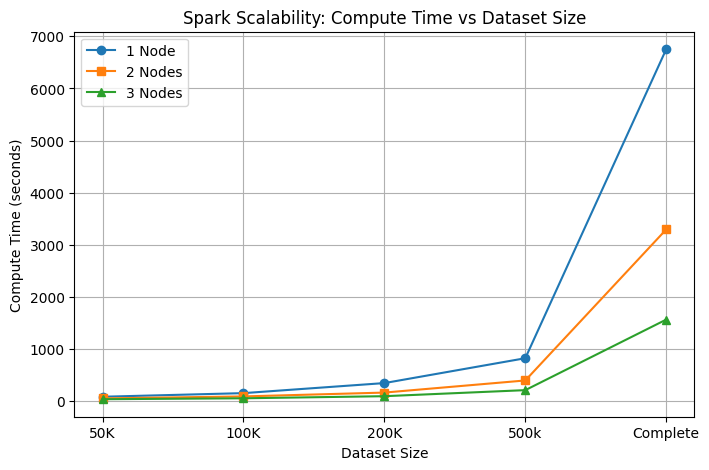

In [18]:
import matplotlib.pyplot as plt

# Dataset categories
dataset_sizes = ["50K", "100K", "200K", "500k", "Complete"]

# Reorganize data by node count
compute_time_1_node = [times_50k[0], times_100k[0], times_200k[0], times_500k[0], times_full[0]]
compute_time_2_nodes = [times_50k[1], times_100k[1], times_200k[1], times_500k[1], times_full[1]]
compute_time_3_nodes = [times_50k[2], times_100k[2], times_200k[2], times_500k[2], times_full[2]]

# X positions for categorical plotting
x_positions = range(len(dataset_sizes))

# Plot the data
plt.figure(figsize=(8, 5))
plt.plot(x_positions, compute_time_1_node, marker='o', linestyle='-', label="1 Node")
plt.plot(x_positions, compute_time_2_nodes, marker='s', linestyle='-', label="2 Nodes")
plt.plot(x_positions, compute_time_3_nodes, marker='^', linestyle='-', label="3 Nodes")

# Set categorical x-axis labels
plt.xticks(x_positions, dataset_sizes)

# Labels and title
plt.xlabel("Dataset Size")
plt.ylabel("Compute Time (seconds)")
plt.title("Spark Scalability: Compute Time vs Dataset Size")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()
